In [1]:
import json
import time
from pathlib import Path

import SimpleITK as sitk
import airlab as al
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
THIS_DIR = Path().resolve()
DATA_DIR = Path('/net/birdstore/Active_Atlas_Data/data_root/pipeline_data')

In [3]:
def load_and_prep_images(
    mov_img_dir, mov_img_thumb_dir,
    fix_img_dir, fix_img_thumb_dir,
    downsample_factor=(1, 1, 1)
):
    mov_img_size = get_tif_size(mov_img_dir / '000.tif')
    mov_img_thumb_size = get_tif_size(mov_img_thumb_dir / '000.tif')
    fix_img_size = get_tif_size(fix_img_dir / '000.tif')
    fix_img_thumb_size = get_tif_size(fix_img_thumb_dir / '000.tif')
    print('Moving image size:', mov_img_size)
    print('Moving image thumbnail size:', mov_img_thumb_size)
    print('Fixed image size:', fix_img_size)
    print('Fixed image thumbnail size:', fix_img_thumb_size)

    print('Loading moving image stack')
    mov_img_stack = load_image_stack(mov_img_thumb_dir)
    imshow_midslice(mov_img_stack)
    print('Loading fixed image stack')
    fix_img_stack = load_image_stack(fix_img_thumb_dir)
    imshow_midslice(fix_img_stack)

    print('Normalizing image intensity')
    mov_img_stack = normalize_intensity(mov_img_stack)
    fix_img_stack = normalize_intensity(fix_img_stack)

    print('Padding image')
    mov_img_stack, fix_img_stack = pad([mov_img_stack, fix_img_stack])

    print('Downsampling image')
    dx, dy, dz = downsample_factor
    mov_img_stack = mov_img_stack[::dx, ::dy, ::dz]
    fix_img_stack = fix_img_stack[::dx, ::dy, ::dz]

    imshow_midslice(mov_img_stack)
    imshow_midslice(fix_img_stack)
    
    print('Converting to airlab image')
    dtype = torch.float32
    device = torch.device('cpu')
    origin = (0, 0, 0)
    downsample_factor = np.array(downsample_factor)
    
    def prep_al_img(img, size, thumb_size):
        spacing = np.append(size / thumb_size, 1) * downsample_factor
        img = torch.tensor(img, dtype=dtype).to(device)
        img = al.Image(img, img.shape, spacing, origin)
        return img

    mov_img = prep_al_img(mov_img_stack, mov_img_size, mov_img_thumb_size)
    fix_img = prep_al_img(fix_img_stack, fix_img_size, fix_img_thumb_size)

    return mov_img, fix_img

def affine_registrate(
    mov_img, fix_img,
    lr=None, niter=None 
):  
    start = time.time()

    registration = al.PairwiseRegistration(verbose=True)

    transformation = al.transformation.pairwise.AffineTransformation(mov_img)
    registration.set_transformation(transformation)

    image_loss = al.loss.pairwise.MSE(fix_img, mov_img)
    registration.set_image_loss([image_loss])

    optimizer = torch.optim.Adam(transformation.parameters(), lr=lr)
    registration.set_optimizer(optimizer)

    registration.set_number_of_iterations(niter)
    registration.start()

    end = time.time()
    print((end - start) / 60, 'min')
    return transformation
    
def get_tif_size(tif_file):
    file_reader = sitk.ImageFileReader()
    file_reader.SetFileName(tif_file.as_posix())
    file_reader.ReadImageInformation()
    return np.array(file_reader.GetSize())

def load_image_stack(image_dir):
    image_dir = Path(image_dir).resolve()
    image_stack = []
    for image_file in sorted(image_dir.iterdir()):
        print(f'Loading image {image_file.name}', end='\r')
        image = sitk.ReadImage(image_file.as_posix())
        image_arr = sitk.GetArrayViewFromImage(image).copy()
        image_stack.append(image_arr.T)
    print(f'Finished loading {len(image_stack)} images')
    image_stack = np.stack(image_stack, axis=-1)
    return image_stack

def imshow_midslice(image, ax=None):
    if ax == None:
        _, ax = plt.subplots(1, 3)
    mid_x, mid_y, mid_z = np.array(image.shape) // 2
    kwargs = {
        'aspect':'equal',
        'cmap': 'gray',
    }
    ax[0].imshow(image[:,:,mid_z], **kwargs)
    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x0')
    ax[1].imshow(image[:,mid_y,:], **kwargs)
    ax[1].set_xlabel('x2')
    ax[1].set_ylabel('x0')
    ax[2].imshow(image[mid_x,:,:], **kwargs)
    ax[2].set_xlabel('x2')
    ax[2].set_ylabel('x1')
    plt.tight_layout()
    plt.show()
    
def normalize_intensity(image):
    v_min, v_max = image.min(), image.max()
    image = (image - v_min) / (v_max - v_min)
    return image

def pad(images):
    shape = np.array(list(map(lambda image: image.shape, images))).max(axis=0)

    def put_in_corner(canvas, image):
        dx, dy, dz = image.shape
        canvas[0:dx,0:dy,0:dz] = image
        
    padded_images = []
    for image in images:
        canvas = np.zeros(shape, dtype=image.dtype)
        put_in_corner(canvas, image)
        padded_images.append(canvas)
    return padded_images

In [4]:
def process_brain(brain_name):
    mov_img_dir = DATA_DIR / 'DK52' / 'preps/CH1/full_aligned'
    mov_img_thumb_dir = DATA_DIR / 'DK52' / 'preps/CH1/thumbnail_aligned'
    fix_img_dir = DATA_DIR / brain_name / 'preps/CH1/full_aligned'
    fix_img_thumb_dir = DATA_DIR / brain_name / 'preps/CH1/thumbnail_aligned'
    transformation_file = THIS_DIR / f'{brain_name}_transformation.json'
    coms_file = THIS_DIR / f'{brain_name}_coms.json'
    
    mov_img, fix_img = load_and_prep_images(
        mov_img_dir, mov_img_thumb_dir,
        fix_img_dir, fix_img_thumb_dir,
        downsample_factor=(8, 8, 2)
    )
    
    transformation = affine_registrate(
        mov_img, fix_img,
        lr=1e-2, niter=64
    )
    
    displacement = transformation.get_displacement()
    wrp_img = al.transformation.utils.warp_image(mov_img, displacement)
    print('Moving image:')
    imshow_midslice(mov_img.image[0,0].numpy())
    print('Warped image:')
    imshow_midslice(wrp_img.image[0,0].numpy())
    print('Fixed image:')
    imshow_midslice(fix_img.image[0,0].numpy())
    
    affine_matrix = transformation.transformation_matrix.t().detach().numpy()
    
    a = affine_matrix[:3,:]
    t = affine_matrix[3,:]
    a_inv = np.linalg.inv(a)
    t_inv = - t @ a_inv
    affine_matrix_inv = np.vstack((a_inv, t_inv))

    affine_transformation = {}
    affine_transformation['mov_spacing'] = mov_img.spacing.tolist()
    affine_transformation['fix_spacing'] = fix_img.spacing.tolist()
    affine_transformation['box_size'] = list(fix_img.size)
    affine_transformation['affine_matrix'] = affine_matrix_inv.tolist()
    affine_transformation['affine_matrix_inv'] = affine_matrix.tolist()
    with transformation_file.open('w') as f:
        json.dump(affine_transformation, f, indent=4)
        
    with open('DK52_coms.json', 'r') as f:
        mov_coms = json.load(f)
        
    with open(transformation_file, 'r') as f:
        transform = json.load(f)
        
    mov_spacing = np.array(transform['mov_spacing'])
    fix_spacing = np.array(transform['fix_spacing'])
    box_size = np.array(transform['box_size'])
    affine_matrix = np.array(transform['affine_matrix'])
    
    fix_coms = {}
    for name, com in mov_coms.items():
        com = np.array(com, dtype=float)
        # the folowing transformation is very tricky
        # had to figure it out from airlab source code
        com /= mov_spacing
        com = com / box_size * 2 - 1
        com = np.append(com, 1) @ affine_matrix
        com = (com + 1) / 2 * box_size
        com *= fix_spacing
        fix_coms[name] = com.tolist()
    with open(coms_file, 'w') as f:
        json.dump(fix_coms, f, sort_keys=True, indent=4)

Moving image size: [65000 36000]
Moving image thumbnail size: [2031 1125]
Fixed image size: [55800 33600]
Fixed image thumbnail size: [1743 1050]
Loading moving image stack
Finished loading 486 images


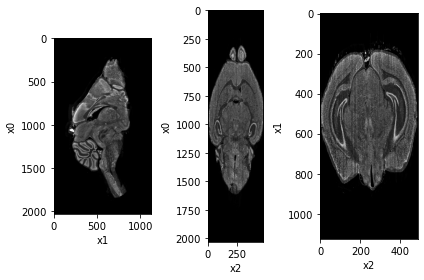

Loading fixed image stack
Finished loading 469 images


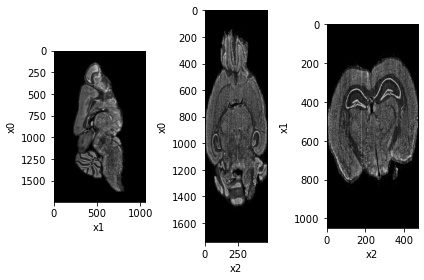

Normalizing image intensity
Padding image
Downsampling image


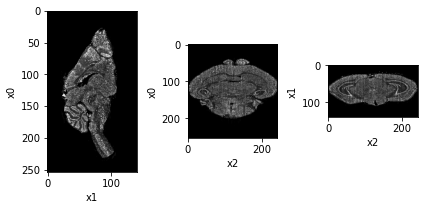

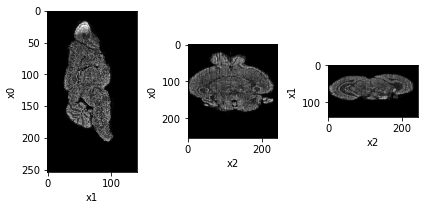

Converting to airlab image
0 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


mse: 0.01455975417047739 
1 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


mse: 0.013900171034038067 
2 mse: 0.013787131756544113 
3 mse: 0.013660450465977192 
4 mse: 0.01355156023055315 
5 mse: 0.013486471958458424 
6 mse: 0.013360989280045033 
7 mse: 0.013190669938921928 
8 mse: 0.01300703827291727 
9 mse: 0.012825804762542248 
10 mse: 0.012680836021900177 
11 mse: 0.01257534883916378 
12 mse: 0.012487045489251614 
13 mse: 0.012411166913807392 
14 mse: 0.012334873899817467 
15 mse: 0.012175410985946655 
16 mse: 0.011935794726014137 
17 mse: 0.011665320955216885 
18 mse: 0.011392796412110329 
19 mse: 0.01114497147500515 
20 mse: 0.010956823825836182 
21 mse: 0.01081907469779253 
22 mse: 0.010697074234485626 
23 mse: 0.010594362393021584 
24 mse: 0.010586722753942013 
25 mse: 0.010686595924198627 
26 mse: 0.010743317194283009 
27 mse: 0.01068788766860962 
28 mse: 0.010570931248366833 
29 mse: 0.010437565855681896 
30 mse: 0.010340946726500988 
31 mse: 0.010281314142048359 
32 mse: 0.010183756239712238 
33 mse: 0.010039916262030602 
34 mse: 0.00992836896330118

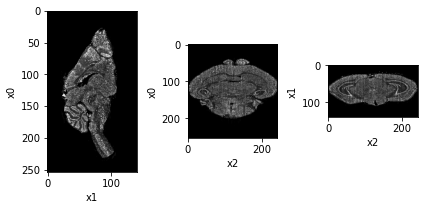

Warped image:


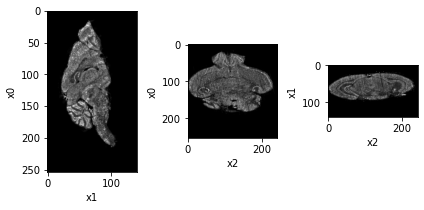

Fixed image:


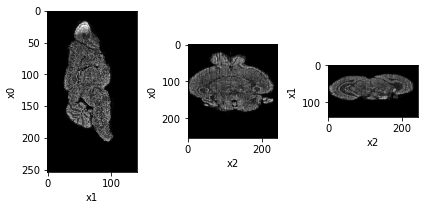

In [5]:
process_brain('DK39')

Moving image size: [65000 36000]
Moving image thumbnail size: [2031 1125]
Fixed image size: [57600 32000]
Fixed image thumbnail size: [1800 1000]
Loading moving image stack
Finished loading 486 images


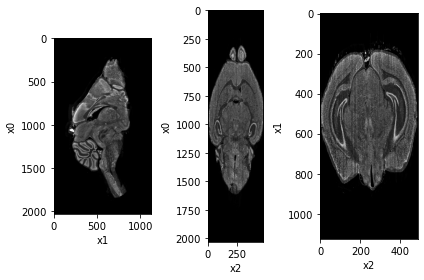

Loading fixed image stack
Finished loading 467 images


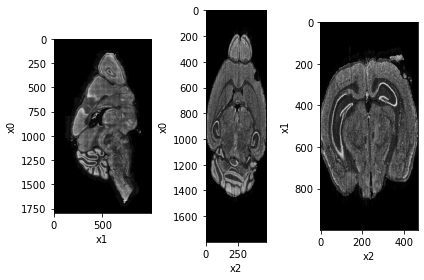

Normalizing image intensity
Padding image
Downsampling image


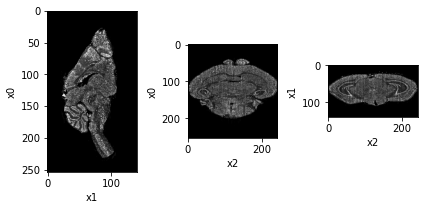

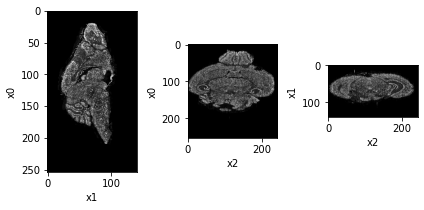

Converting to airlab image
0 mse: 0.014672607183456421 
1 mse: 0.014015477150678635 
2 mse: 0.013478655368089676 
3 mse: 0.013077625073492527 
4 mse: 0.012718688696622849 
5 mse: 0.012410960160195827 
6 mse: 0.012193323113024235 
7 mse: 0.012121974490582943 
8 mse: 0.012139796279370785 
9 mse: 0.01220414787530899 
10 mse: 0.012222254648804665 
11 mse: 0.012101849541068077 
12 mse: 0.011889875866472721 
13 mse: 0.01157035119831562 
14 mse: 0.011163606308400631 
15 mse: 0.01075419969856739 
16 mse: 0.010361080057919025 
17 mse: 0.010055203922092915 
18 mse: 0.009858543984591961 
19 mse: 0.009897751733660698 
20 mse: 0.0099410992115736 
21 mse: 0.009842884726822376 
22 mse: 0.009699871763586998 
23 mse: 0.009504562243819237 
24 mse: 0.009387354366481304 
25 mse: 0.009344362653791904 
26 mse: 0.009225725196301937 
27 mse: 0.009051540866494179 
28 mse: 0.008818615227937698 
29 mse: 0.008595562539994717 
30 mse: 0.008531808853149414 
31 mse: 0.008609673008322716 
32 mse: 0.008718948811292648

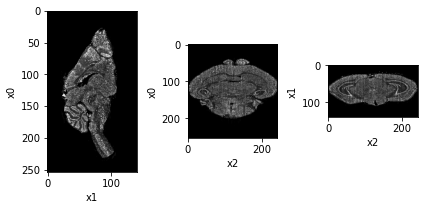

Warped image:


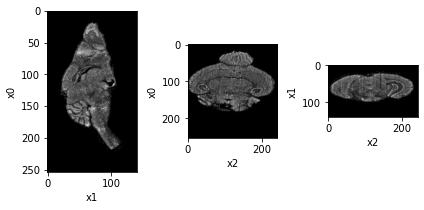

Fixed image:


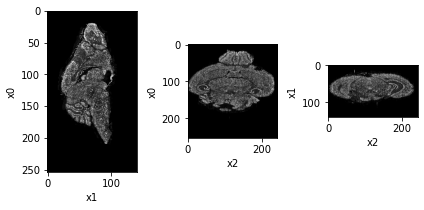

In [6]:
process_brain('DK41')

Moving image size: [65000 36000]
Moving image thumbnail size: [2031 1125]
Fixed image size: [54000 32000]
Fixed image thumbnail size: [1687 1000]
Loading moving image stack
Finished loading 486 images


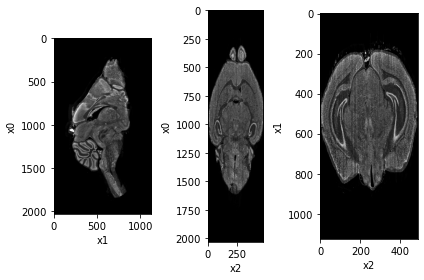

Loading fixed image stack
Finished loading 392 images


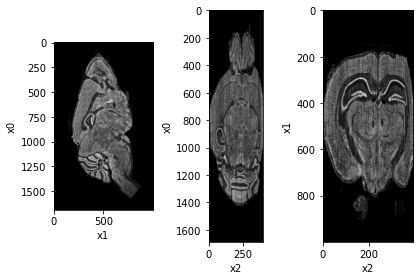

Normalizing image intensity
Padding image
Downsampling image


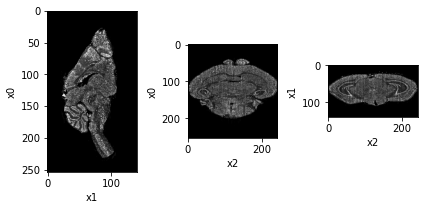

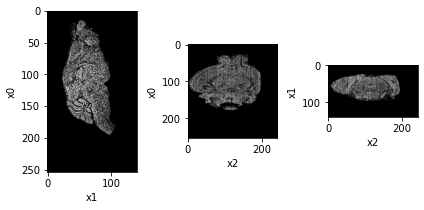

Converting to airlab image
0 mse: 0.015228313393890858 
1 mse: 0.014570772647857666 
2 mse: 0.014218807220458984 
3 mse: 0.013783772476017475 
4 mse: 0.013281818479299545 
5 mse: 0.012918522581458092 
6 mse: 0.012719381600618362 
7 mse: 0.012556507252156734 
8 mse: 0.012402207590639591 
9 mse: 0.012247804552316666 
10 mse: 0.012108957394957542 
11 mse: 0.011954414658248425 
12 mse: 0.011820407584309578 
13 mse: 0.011693546548485756 
14 mse: 0.01157184038311243 
15 mse: 0.011528227478265762 
16 mse: 0.01153792068362236 
17 mse: 0.011594164185225964 
18 mse: 0.011662974953651428 
19 mse: 0.0117166917771101 
20 mse: 0.011723426170647144 
21 mse: 0.011688741855323315 
22 mse: 0.011617553420364857 
23 mse: 0.011504133231937885 
24 mse: 0.011389708146452904 
25 mse: 0.01126659382134676 
26 mse: 0.011151328682899475 
27 mse: 0.011112626641988754 
28 mse: 0.011092737317085266 
29 mse: 0.011076708324253559 
30 mse: 0.011072216555476189 
31 mse: 0.011050804518163204 
32 mse: 0.011042594909667969

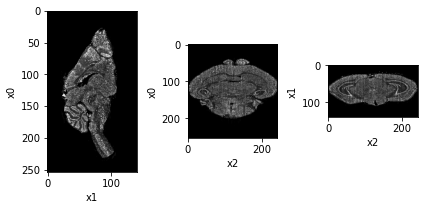

Warped image:


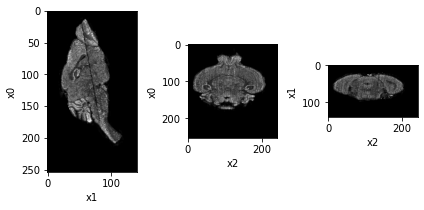

Fixed image:


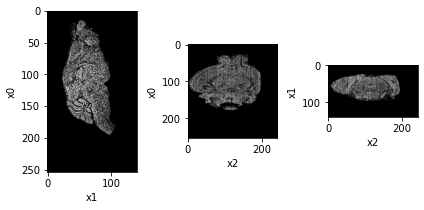

In [7]:
process_brain('DK43')

Moving image size: [65000 36000]
Moving image thumbnail size: [2031 1125]
Fixed image size: [60000 38000]
Fixed image thumbnail size: [1875 1187]
Loading moving image stack
Finished loading 486 images


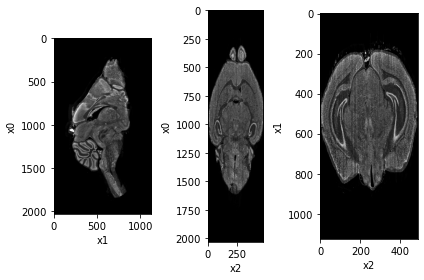

Loading fixed image stack
Finished loading 384 images


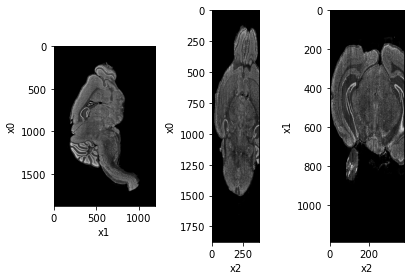

Normalizing image intensity
Padding image
Downsampling image


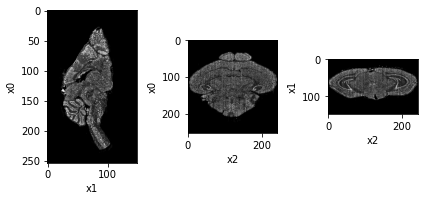

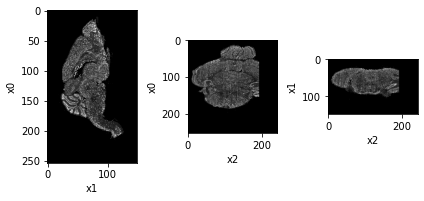

Converting to airlab image
0 mse: 0.01457494031637907 
1 mse: 0.014114446938037872 
2 mse: 0.013947986997663975 
3 mse: 0.013575001619756222 
4 mse: 0.013150294311344624 
5 mse: 0.012797022238373756 
6 mse: 0.012519222684204578 
7 mse: 0.012372144497931004 
8 mse: 0.012297273613512516 
9 mse: 0.012270256876945496 
10 mse: 0.012292294763028622 
11 mse: 0.012305176816880703 
12 mse: 0.01229579746723175 
13 mse: 0.012225908227264881 
14 mse: 0.012191291898488998 
15 mse: 0.012214228510856628 
16 mse: 0.012247273698449135 
17 mse: 0.012214291840791702 
18 mse: 0.012103959918022156 
19 mse: 0.01195512805134058 
20 mse: 0.011755552142858505 
21 mse: 0.011560370214283466 
22 mse: 0.011424410156905651 
23 mse: 0.011355618014931679 
24 mse: 0.011316238902509212 
25 mse: 0.011247395537793636 
26 mse: 0.011135420762002468 
27 mse: 0.011023162864148617 
28 mse: 0.010957126505672932 
29 mse: 0.010911239311099052 
30 mse: 0.010860414244234562 
31 mse: 0.010804342105984688 
32 mse: 0.0107528464868664

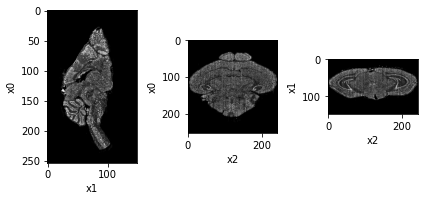

Warped image:


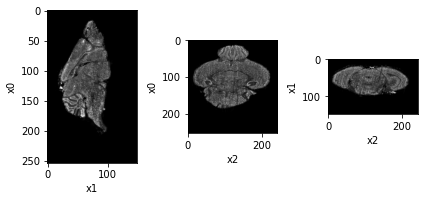

Fixed image:


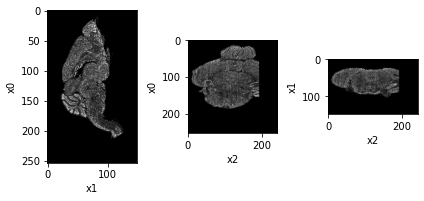

In [8]:
process_brain('DK54')

Moving image size: [65000 36000]
Moving image thumbnail size: [2031 1125]
Fixed image size: [60000 34000]
Fixed image thumbnail size: [1875 1062]
Loading moving image stack
Finished loading 486 images


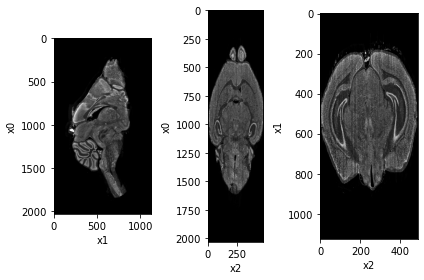

Loading fixed image stack
Finished loading 485 images


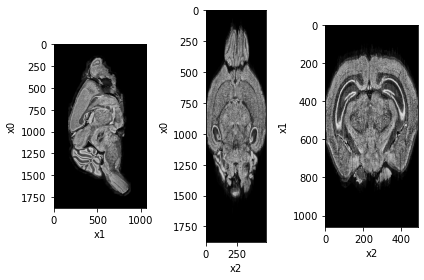

Normalizing image intensity
Padding image
Downsampling image


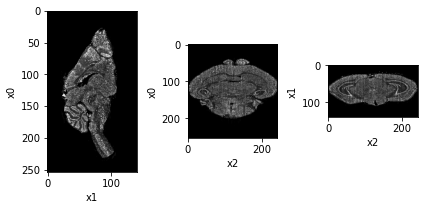

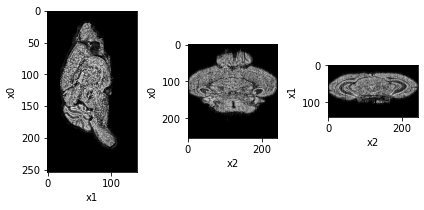

Converting to airlab image
0 mse: 0.023117536678910255 
1 mse: 0.02300179749727249 
2 mse: 0.022848738357424736 
3 mse: 0.022480716928839684 
4 mse: 0.022184161469340324 
5 mse: 0.021900633350014687 
6 mse: 0.021512316539883614 
7 mse: 0.021128874272108078 
8 mse: 0.02084207721054554 
9 mse: 0.020652037113904953 
10 mse: 0.020356636494398117 
11 mse: 0.019890783354640007 
12 mse: 0.019307520240545273 
13 mse: 0.01868690922856331 
14 mse: 0.01812734268605709 
15 mse: 0.01767369545996189 
16 mse: 0.017431536689400673 
17 mse: 0.017570659518241882 
18 mse: 0.0175765473395586 
19 mse: 0.01746719516813755 
20 mse: 0.01749696023762226 
21 mse: 0.017590360715985298 
22 mse: 0.017576489597558975 
23 mse: 0.017506252974271774 
24 mse: 0.017425840720534325 
25 mse: 0.017265425994992256 
26 mse: 0.01702025905251503 
27 mse: 0.016760792583227158 
28 mse: 0.016659840941429138 
29 mse: 0.0167668629437685 
30 mse: 0.016840731725096703 
31 mse: 0.01678471453487873 
32 mse: 0.016643159091472626 
33 mse

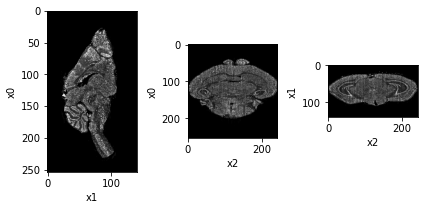

Warped image:


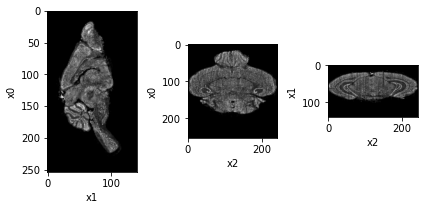

Fixed image:


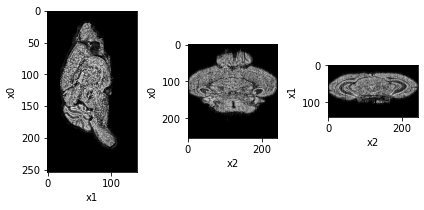

In [9]:
process_brain('DK55')